# Detecção de Fraudes em Pagamentos - PaySim

### Bibliotecas

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input/datasetinf'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## modelo
from sklearn import preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, mean_absolute_error, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve


## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter

# check xgboost version
from xgboost import XGBClassifier

import timeit
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/datasetinf/describe.csv
/kaggle/input/datasetinf/PS_20174392719_1491204439457_log.csv
/kaggle/input/datasetinf/paysim_predicted.csv


### Layout

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16,
    'axes.titlesize': 18, 'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(rc=rc)
sns.set_style("darkgrid")
sns.set_palette("pastel")

### Configurações

In [2]:
#pd.set_option('max_columns', 200)
pd.options.display.max_columns = 200 

# Define um valor maior para a largura máxima das colunas
pd.options.display.max_colwidth = 1000

seed = 42
np.random.seed(seed)

### Funções

In [3]:
def check_time(start, end):
    seg = end - start
    dias = seg // 86400
    Seg_Restantes_Após_Dias = seg % 86400
    horas = Seg_Restantes_Após_Dias // 3600         # Divisão inteira
    Seg_Restantes_Apos_Hora = seg % 3600            # Resto da divisão por 3600
    minutos = Seg_Restantes_Apos_Hora // 60         # Divisão inteira dos segundos restantes
    Seg_Restantes_Apos_Minutos = seg % 60
    #print(minutos,'minutos','e', '%.2f' % Seg_Restantes_Apos_Minutos,'segundos')
    print(dias,'dias', horas,'horas', minutos,'minutos','e', '%.2f' % Seg_Restantes_Apos_Minutos,'segundos')

start=timeit.default_timer()

In [4]:
def aucur(y_test, preds):
    # calculate AUC
    aucur = roc_auc_score(y_test, preds)
    print('AUC: %.3f' % aucur)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # plot no skill
    plt.figure(figsize=(4, 3))
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.show()

In [5]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [6]:
def plot_feature_freq(df, feature, top_n=10):
    value_counts = df[feature].value_counts(dropna=True)
    top_values = value_counts.head(top_n)
    other_values_count = value_counts.iloc[top_n:].sum()

    if other_values_count > 0:
        top_values['Outros'] = other_values_count

    total = top_values.sum()

    plt.figure(figsize=(5, 4))
    ax = sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')

    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        percentage = p.get_height() / total * 100
        ax.annotate('{:.1f}%'.format(percentage), (p.get_x() + p.get_width() / 2., 0),
                    ha='center', va='center', xytext=(0, -40), textcoords='offset points')

    ax.set(xlabel='isFraud', ylabel='Quantidade')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

***
# 1) Definição do problema e objetivo do projeto

## 1.1) Contexto

Apresentamos um conjunto de dados sintético gerado usando o simulador denominado PaySim como uma abordagem para tal problema. PaySim usa dados agregados do conjunto de dados privado para gerar um conjunto de dados sintético que se assemelha à operação normal das transações e injeta comportamento malicioso para avaliar posteriormente o desempenho dos métodos de detecção de fraude.

## 1.2) Sobre o Conteudo

PaySim simula transações de dinheiro móvel com base em uma amostra de transações reais extraídas de um mês de registros financeiros de um serviço de dinheiro móvel implementado em um país africano. Os registos originais foram fornecidos por uma empresa multinacional, fornecedora do serviço financeiro móvel que funciona atualmente em mais de 14 países em todo o mundo.

Este conjunto de dados sintético foi reduzido em 1/4 do conjunto de dados original e foi criado apenas para Kaggle.

## 1.3) Dicionario de dados

In [7]:
dicionario = pd.read_csv('/kaggle/input/datasetinf/describe.csv', delimiter=';', header=None, encoding='latin1', index_col=None)
dicionario

,0,1
0,step,"mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo equivale a 1 hora. Total de passos 744 (simulação de 30 dias)."
1,type,"CASH-IN, CASH-OUT, DÉBITO, PAGAMENTO e TRANSFERÊNCIA."
2,amount,valor da transação em moeda local.
3,nameOrig,cliente que iniciou a transação
4,oldbalanceOrg,saldo inicial antes da transação
5,newbalanceOrig,novo saldo após a transação.
6,nameDest,cliente que é o destinatário da transação
7,oldbalanceDest,destinatário do saldo inicial antes da transação. Observe que não há informações para clientes que iniciam com M (Comerciantes).
8,newbalanceDest,novo destinatário do saldo após a transação. Observe que não há informações para clientes que iniciam com M (Comerciantes).
9,isFraud,"São as transações realizadas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar assumindo o controle das contas dos clientes e tentando esvaziar os fundos transferindo para outra conta e depois sacando do sistema."


***
# 2) Coleta e preparação dos dados

## 2.1) Coleta dos dados - Modelagem

In [8]:
# treinamento
df = pd.read_csv('/kaggle/input/datasetinf/PS_20174392719_1491204439457_log.csv')

# isFlaggedFraud foi excluido pois o modelo pode usar esta coluna como referencia para prever fraudes
df = df.drop(['isFlaggedFraud'],axis=1)

print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1
3     1  CASH_OUT    181.00   C840083671          181.0            0.00    C38997010         21182.0             0.0        1
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86  M1230701703             0.0             0.0        0


In [9]:
df.shape

(6362620, 10)

## 2.2) Checar dados faltantes

In [12]:
just_check_nan(df)

Dados com NaN:
Series([], dtype: int64)

columns_with_nan.shape (0,)



## 2.3) Apagando dados faltantes

No caso deste problema, não há dados faltantes.

Quando houver dados faltantes, o ideal é averiguar com a área requisitante o motivo dos dados faltantes, e se mesmo assim persistir a falta, podemos:

   - Fill nos dados faltantes com:
       - Valores fixos (SimpleImputer)
       - Valores Média, Mediana e Moda (reduz a variação no conjunto de dados)
       - Previsão (KNN)


### 2.3.1) Exemplos de possiveis tratamentos de dados

In [13]:
### Se houvesse dados faltantes, rodaria a função abaixo para deletar linhas faltantes, caso fosse seguir este caminho
# df_dropped = df.dropna().reset_index(drop=True) 

### Preencher NaN com a média de cada coluna
# df_media = df.fillna(df.mean())

### Preencher NaN com a mediana de cada coluna
# df_mediana = df.fillna(df.median())

### Preencher NaN com a moda de cada coluna
# df_moda = df.apply(lambda x: x.fillna(x.mode().iloc[0]))


### 2.3.2) Checando novamente dados faltantes

In [14]:
# just_check_nan(df_dropped)

### 2.3.2) Checagem e mudança de Tipagem

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


## 2.4) Preparação dos dados

### 2.4.1) Seleção de Features - Feature Importance - Criado em outro notebook (2_infracom-feature-importance)

In [16]:
X = df.drop(['isFraud'], axis=1) # escolhidas Feature Importance - Criado em outro notebook

X

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00


### 2.4.2) Seleção do Target - Classe extremamente desbalanceada, será usado oversampling SMOTE para equilibrar as classes para o treinamento

In [17]:
# define target
y = df['isFraud']

In [18]:
# contagem de classes
c_y = Counter(y)
c_y

Counter({0: 6354407, 1: 8213})

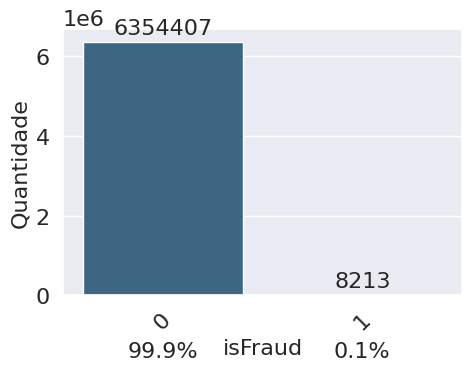

In [19]:
plot_feature_freq(df, 'isFraud')

### 2.4.3) Variaveis Categoricas

In [20]:
# Criando uma lista de variaveis categoricas
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  3
['type', 'nameOrig', 'nameDest']


### 2.4.4) Variaveis Numéricas

In [21]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  6
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


***
# 3) Modelagem dos dados

## 3.1) Dividindo as features em dados de treino e validação

stratify é útil para garantir que a distribuição das classes (ou características importantes) seja mantida em ambas as partes do conjunto de dados. Isso é especialmente importante quando se trabalha com conjuntos de dados desbalanceados, nos quais as classes têm números discrepantes de amostras.

In [22]:
# Dividindo as features em dados de treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.7, 
                                                  stratify=y, # garantir a distribuição das classes seja mantida no conjunto de dados
                                                  random_state = 2048)

## 3.2) Pipeline 

### 3.1) Pré-processamento para Dados Numéricos

StandardScaler resulta em uma distribuição com desvio padrão igual a 1. A variância também é igual a 1, porque variância = desvio padrão ao quadrado. E 1 ao quadrado = 1.

StandardScaler torna a média da distribuição 0. Cerca de 68% dos valores estarão entre -1 e 1.

Os algoritmos de aprendizado profundo geralmente exigem média zero e variação de unidade. Algoritmos do tipo regressão também se beneficiam de dados normalmente distribuídos com tamanhos de amostra pequenos.

In [23]:
# Pré-processamento para Dados Numéricos
numerical_transformer = Pipeline([
                                  ('scaler', StandardScaler())
                                 ])

### 3.2) Pré-processamento para Dados Categóricos

In [24]:
# Pré-processamento para Dados Categóricos
categorical_transformer = Pipeline([
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                   ])

### 3.3) Pré-processamento de pacote de dados numéricos e categóricos

In [25]:
# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor = ColumnTransformer(transformers=[
                                                ('num', numerical_transformer, numerical_cols),
                                                ('cat', categorical_transformer, object_cols)
                                              ], n_jobs=-1)

### 3.4) Pipeline

In [26]:
pipeline = Pipeline(steps=[
                            ('preprocessor', preprocessor),
#                             ('imputation', KNNImputer()), # usaria esta função caso optasse em preencher os dados vazios com knn
                            ('smote', SMOTE(random_state=42, n_jobs=-1)),
                            ('model', XGBClassifier(random_state=2048, n_jobs=-1))
                          ])

### 3.5) Fit

In [27]:
# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type', 'nameOrig',
                                                   'nameDest'])])),
                ('smote', SMOTE(n_jobs=-1, ra...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=2048, ...))])

### 3.6) Previsão

In [28]:
preds = pipeline.predict(X_val)
# preds

In [29]:
# contagem de classes
c_preds = Counter(preds)
c_preds

Counter({0: 4430149, 1: 23685})

***
# 4) Avaliação do modelo

## 4.1) Métricas

### 4.1.1) 'Acurácia' é a quantidade de acertos do nosso modelo dividido pelo total da amostra

A 'acurácia' não é uma medida muito boa para trabalhar com modelos de classificação pois ela pode nos induzir a achar que um modelo
que prediz corretamente todos os zeros mas nenhum um é um modelo muito bom indica uma performance geral do modelo

[VN + VP]/[VN + VP + FN + FP])

In [30]:
def aucur(y_test, preds):
    # calculate AUC
    aucur = roc_auc_score(y_test, preds)
    print('AUC: %.3f' % aucur)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # plot no skill
    plt.figure(figsize=(4, 3))
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.show()

AUC: 0.993


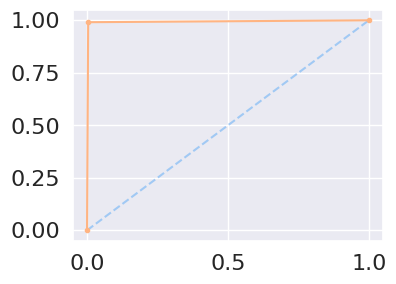

In [31]:
aucur(y_val, preds)

### 4.1.2) Classification Report

In [32]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4448085
           1       0.24      0.99      0.39      5749

    accuracy                           1.00   4453834
   macro avg       0.62      0.99      0.69   4453834
weighted avg       1.00      1.00      1.00   4453834



### 4.1.3) Matriz de Confusão

In [33]:
cm_df = pd.DataFrame(confusion_matrix(y_val, preds),
                     index = sorted(Counter(y_val)),
                     columns = sorted(Counter(preds)))
cm_df

,0,1
0,4430097,17988
1,52,5697


Confusion matrix, without normalization
[[4430097   17988]
 [     52    5697]]
Normalized confusion matrix
[[0.99595601 0.00404399]
 [0.00904505 0.99095495]]


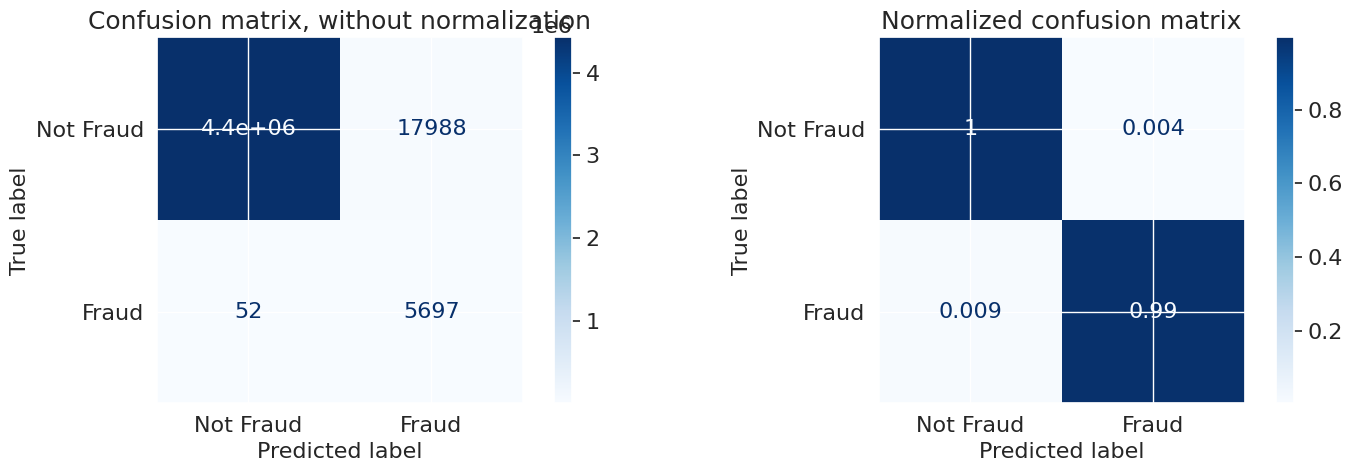

In [34]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

# Criando uma figura geral para as matrizes de confusão
fig, axes = plt.subplots(1, len(titles_options), figsize=(15, 5))

for ax, (title, normalize) in zip(axes, titles_options):
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_val,
        y_val,
        display_labels=['Not Fraud', 'Fraud'],
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax=ax  # Utilizando o eixo específico para cada matriz de confusão
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.tight_layout()  # Ajuste de layout para melhor organização
plt.show()

In [35]:
end=timeit.default_timer()

check_time(start, end)

0.0 dias 0.0 horas 52.0 minutos e 10.24 segundos


### 5) Preparação para salvar os dados com a previsão num arquivo CSV

In [36]:
X_valr = X_val.reset_index(drop=True)
X_valr

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,329,PAYMENT,30581.27,C304280890,0.00,0.00,M1794866928,0.00,0.00
1,398,PAYMENT,22495.13,C1506061797,134850.69,112355.56,M1388898462,0.00,0.00
2,163,PAYMENT,8656.01,C1123454499,0.00,0.00,M797125081,0.00,0.00
3,204,TRANSFER,129428.54,C1521052110,46621.00,0.00,C2057278308,2685396.72,2814825.26
4,35,PAYMENT,9187.37,C581384693,13236.00,4048.63,M990605534,0.00,0.00
...,...,...,...,...,...,...,...,...,...
4453829,180,PAYMENT,29224.87,C1489336574,0.00,0.00,M1253305449,0.00,0.00
4453830,303,PAYMENT,22603.18,C1066608766,0.00,0.00,M877885359,0.00,0.00
4453831,164,CASH_OUT,137925.46,C1997056748,0.00,0.00,C1312873996,4265435.00,4403360.46
4453832,10,CASH_OUT,153793.50,C128460661,0.00,0.00,C1023535667,2510648.09,2925852.96


In [37]:
y_valr = y_val.reset_index(drop=True)
y_valr

0          0
1          0
2          0
3          0
4          0
          ..
4453829    0
4453830    0
4453831    0
4453832    0
4453833    0
Name: isFraud, Length: 4453834, dtype: int64

In [40]:
df_preds = pd.DataFrame(preds, columns=['preds'])
df_preds

,preds
0,0
1,0
2,0
3,0
4,0
...,...
4453829,0
4453830,0
4453831,0
4453832,0


In [41]:
df_output = X_valr.join([y_valr, df_preds]).reset_index(drop=True)
df_output

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,preds
0,329,PAYMENT,30581.27,C304280890,0.00,0.00,M1794866928,0.00,0.00,0,0
1,398,PAYMENT,22495.13,C1506061797,134850.69,112355.56,M1388898462,0.00,0.00,0,0
2,163,PAYMENT,8656.01,C1123454499,0.00,0.00,M797125081,0.00,0.00,0,0
3,204,TRANSFER,129428.54,C1521052110,46621.00,0.00,C2057278308,2685396.72,2814825.26,0,0
4,35,PAYMENT,9187.37,C581384693,13236.00,4048.63,M990605534,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4453829,180,PAYMENT,29224.87,C1489336574,0.00,0.00,M1253305449,0.00,0.00,0,0
4453830,303,PAYMENT,22603.18,C1066608766,0.00,0.00,M877885359,0.00,0.00,0,0
4453831,164,CASH_OUT,137925.46,C1997056748,0.00,0.00,C1312873996,4265435.00,4403360.46,0,0
4453832,10,CASH_OUT,153793.50,C128460661,0.00,0.00,C1023535667,2510648.09,2925852.96,0,0


In [44]:
# Substitua 'meus_dados.csv' pelo nome que você deseja dar ao seu arquivo CSV
df_output.to_csv('/kaggle/working/paysim_predicted.csv', index=False)